In [7]:
import pandas as pd

pulse = pd.read_csv("checkpoints_pulse.csv")
eoc = pd.read_csv("checkpoints_eoc.csv")
merged_df = pd.merge(pulse,eoc, on=["student_id","class_id","book","chapter_number"], how="inner")
merged_df.dropna(inplace=True)
merged_df.to_csv("merged_checkpoints.csv", index=False)

Mean Squared Error (MSE): 1.1819509204963283
R-squared: 0.06266149231773077


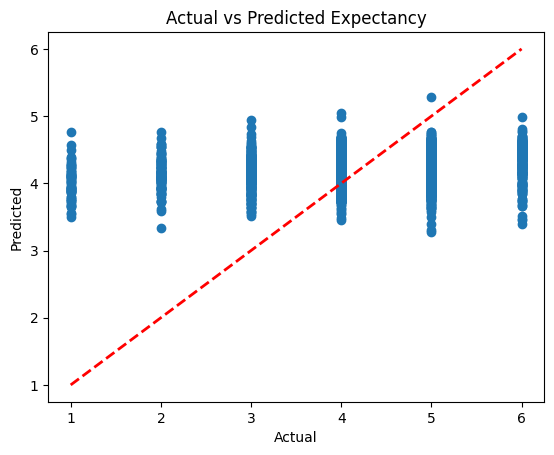

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('merged_checkpoints.csv')

# Filter to include only rows where the construct is 'Expectancy'
expectancy_df = df[df['construct'] == 'Expectancy']

# Define predictors and response
X = expectancy_df[['n_possible', 'n_correct', 'n_attempt']]
y = expectancy_df['response']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the performance metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

# Plot the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Expectancy')
plt.show()


In [9]:
import pandas as pd
from tqdm import tqdm


#CHANGE ME

# Correct the filepath based on your directory structure
filepath = 'C:\\Users\\Japjot\\Downloads\\OneDrive_1_3-22-2024\\full_03_04\\responses.csv'

# Load the data into a DataFrame, adding low_memory=False to avoid DtypeWarning
df = pd.read_csv(filepath, low_memory=False)

# Define a function to safely extract comments
def extract_comments(x):
    # Check if x is a string to avoid AttributeError
    if isinstance(x, str):
        # Split by '#' and strip spaces
        return ' '.join([part.strip() for part in x.split('#') if part.strip()])
    else:
        # Return an empty string or placeholder if x is not a string
        return ''

# Apply the function to the 'response' column
comments = df['response'].apply(extract_comments)

# Open a text file for writing comments
with open('comments.txt', 'w', encoding='utf-8') as file:
    # Iterate over comments with a progress bar
    for i, comment in tqdm(enumerate(comments, start=1), total=comments.shape[0], desc="Writing comments"):
        file.write(f"Comment {i}: {comment}\n\n")

Writing comments: 100%|██████████| 1585274/1585274 [00:03<00:00, 470954.16it/s]


In [ ]:
import re
import csv
from collections import Counter
from textblob import TextBlob
from tqdm import tqdm

def is_human_written(text, repeats):
    """
    Check if the comment is likely to be human-written text.
    
    This function applies various checks to determine if a piece of text
    appears to be human-written, excluding those that meet certain patterns
    suggestive of automated generation, non-text content, or non-constructive input.
    
    Args:
    - text (str): The text to evaluate.
    - repeats (Counter): A Counter object tracking occurrences of each text.
    
    Returns:
    - bool: True if the text is likely human-written, False otherwise.
    """
    if any(symbol in text for symbol in ["\\", "<", ">"]) or '"' in text or re.search(r'c\(["\'].*?["\']\)', text):
        return False
    if text.strip().endswith("?") or text.strip().startswith("-") or re.match(r'^\(\d+\)', text.strip()):
        return False
    if repeats[text.strip()] > 1:
        return False
    if text.count(" ") <= 3:
        return False
    if "_" in text or re.search(r'\(\s*\(.+\)\s*\)', text) or re.search(r'\)\s*\(', text):
        return False
    numerical_or_json_pattern = re.compile(r'\d{1,3}(,\d{3})*(-\d{1,3}(,\d{3})*)?|^\[\s*(".*?"|\d+)(,\s*(".*?"|\d+))*\s*\]$')
    if numerical_or_json_pattern.search(text):
        return False
    code_like_patterns = re.compile(r'<-|=|\b(tail|head|sum|factor|as\.numeric|as\.factor)\b|confint\(Condition_model\)|int\(Condition_model\)')
    if code_like_patterns.search(text):
        return False
    if len(text.strip()) < 10:
        return False
    return True

def process_comments(input_file, output_file):
    """
    Process comments from an input CSV, filtering based on criteria, analyzing sentiment polarity,
    and writing comments with non-zero polarity to a new CSV file.
    """
    with open(input_file, 'r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        comments = [(row['student_id'], row['class_id'], row['book'], row['chapter_number'], row['response']) for row in csv_reader]
    line_counts = Counter(comment[4].strip() for comment in comments)
    
    with open(output_file, 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['student_id', 'class_id', 'book', 'chapter_number', 'response', 'polarity']
        csv_writer = csv.DictWriter(file, fieldnames=fieldnames)
        csv_writer.writeheader()
        
        for student_id, class_id, book, chapter_number, response in tqdm(comments, desc="Processing Comments"):
            if is_human_written(response, line_counts):
                polarity = TextBlob(response).sentiment.polarity
                # Check if polarity is not zero before adding
                if polarity != 0:
                    csv_writer.writerow({
                        'student_id': student_id,
                        'class_id': class_id,
                        'book': book,
                        'chapter_number': chapter_number,
                        'response': response,
                        'polarity': polarity
                    })

# Example call to process the comments
process_comments('responses.csv', 'sanitized_comments_with_ids_polarity.csv')


UnicodeEncodeError: 'charmap' codec can't encode characters in position 2-6: character maps to <undefined>